###1. 라이브러리 불러오기

In [ ]:
import os
import shutil
from torch.utils.data import DataLoader
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms

# Visualization
import cv2
import matplotlib.pyplot as plt
from torchsummary import summary

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


###2. 데이터셋 정의 - 비오염

In [ ]:
# Data loading and transformations
transform = transforms.Compose([
  transforms.RandomHorizontalFlip(),
  transforms.RandomCrop(32, padding=4),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# Use PyTorch's torchvision.transforms.ToTenesor() to convert the dataset to tensor format
train_set = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:05<00:00, 32.4MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Use PyTorch's DataLoader to divide the dataset into mini-batches and load the data
train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=64, shuffle=False)

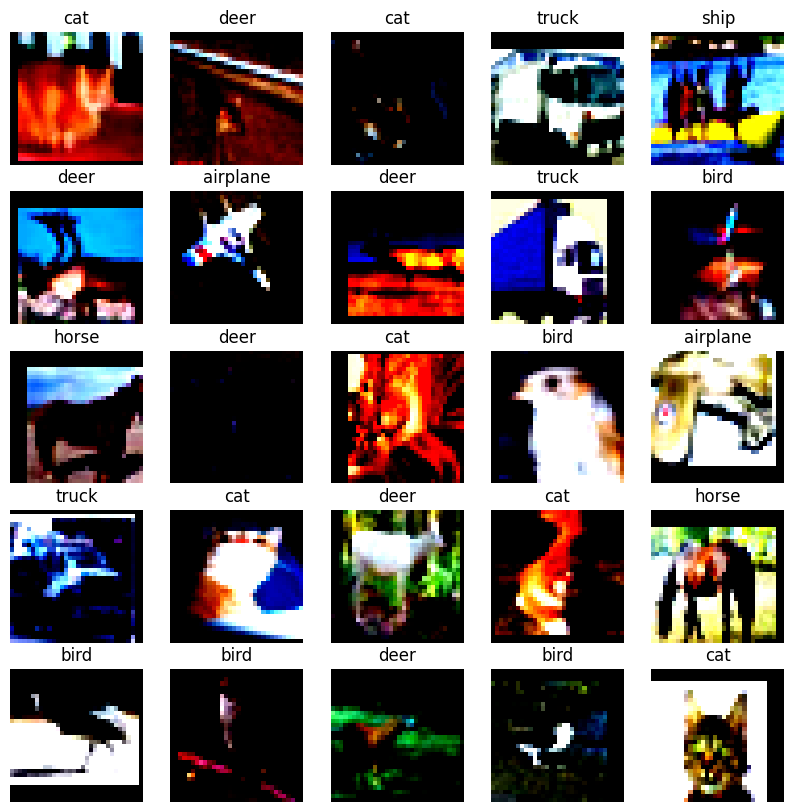

In [ ]:
# Visualization of train dataset samples
import matplotlib.pyplot as plt

classes = train_set.classes

batch = next(iter(train_loader))
images, labels = batch

grid_img = torchvision.utils.make_grid(images[:25], nrow=5, padding=5)

# Display titles below each image
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].permute(1, 2, 0))  # Permute dimensions for matplotlib (C, H, W) -> (H, W, C)
    plt.title(classes[labels[i]])
    plt.axis('off')
plt.show()

###3. 신경망 코딩 - ResNet50

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

In [ ]:
# ResNet50 모델 신경망 생성 및 장치에 저장
model_res = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)

###4. 신경망 학습과 테스트 진행

In [ ]:
# Evaluate function
def evaluate(model, device, test_loader):
  model.eval()
  total_correct = 0
  with torch.no_grad():
     for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      _, preds = torch.max(output, 1)
      total_correct += (preds == target).sum().item()

  accuracy = 100 * total_correct / len(test_loader.dataset)
  return accuracy

In [ ]:
# Train and evaluate function
def train_and_evaluate(model, device, train_loader, test_loader, epochs=5):
  model.train()

  criterion = nn.CrossEntropyLoss()
  # optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9, weight_decay=1e-4)

  accuracies = []

  for epoch in range(epochs):
    running_loss = 0.0
    data_iterator = iter(train_loader)
    for inputs, labels in data_iterator:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'[Epoch {epoch + 1}] loss: {running_loss / len(train_loader):.3f}')

    accuracy = evaluate(model, device, test_loader)
    accuracies.append(accuracy)
    print(f'Accuracy: {accuracy:.2f}%')

  return accuracies

In [ ]:
acc_res = train_and_evaluate(model_res, device, train_loader, test_loader, epochs=5)

[Epoch 1] loss: 1.613
Accuracy: 48.67%
[Epoch 2] loss: 1.312
Accuracy: 62.14%
[Epoch 3] loss: 1.019
Accuracy: 65.45%
[Epoch 4] loss: 0.870
Accuracy: 67.16%
[Epoch 5] loss: 0.746
Accuracy: 70.01%


###5. 데이터의 오염을 통한 학습 효율 변화

Running experiment with no corruption
[Epoch 1] loss: 1.615
Accuracy: 52.41%
[Epoch 2] loss: 1.282
Accuracy: 60.93%
[Epoch 3] loss: 1.019
Accuracy: 65.39%
[Epoch 4] loss: 0.863
Accuracy: 70.97%
[Epoch 5] loss: 0.752
Accuracy: 74.50%
Running experiment with 20.0% corruption
Files already downloaded and verified
Files already downloaded and verified
[Epoch 1] loss: 1.642
Accuracy: 47.44%
[Epoch 2] loss: 1.592
Accuracy: 52.36%
[Epoch 3] loss: 1.224
Accuracy: 61.07%
[Epoch 4] loss: 1.074
Accuracy: 65.00%
[Epoch 5] loss: 0.954
Accuracy: 67.43%
Running experiment with 40.0% corruption
Files already downloaded and verified
Files already downloaded and verified
[Epoch 1] loss: 1.685
Accuracy: 49.49%
[Epoch 2] loss: 1.875
Accuracy: 40.39%
[Epoch 3] loss: 1.458
Accuracy: 49.69%
[Epoch 4] loss: 1.291
Accuracy: 57.87%
[Epoch 5] loss: 1.160
Accuracy: 59.00%
Running experiment with 60.0% corruption
Files already downloaded and verified
Files already downloaded and verified
[Epoch 1] loss: 1.729
Accu

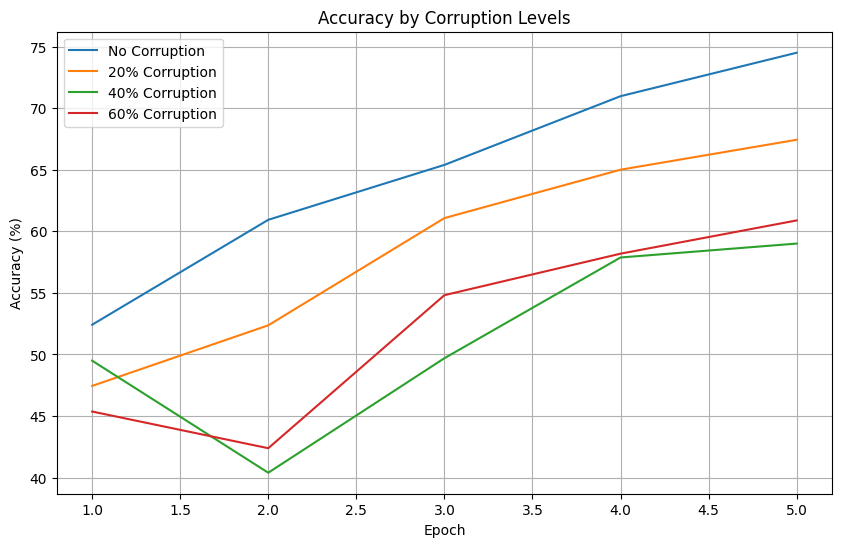

In [ ]:
import random
import matplotlib.pyplot as plt

# 1. 결손 처리 함수 수정
def corrupt_image(image, corruption_fraction):
    """이미지의 일부 픽셀을 결손 처리합니다."""
    image_np = image.numpy()  # 텐서를 NumPy 배열로 변환
    total_pixels = image_np.size
    num_corrupted_pixels = int(total_pixels * corruption_fraction)

    # 랜덤으로 픽셀 선택 (이미지의 플랫(flat) 배열에서 인덱스 기준)
    indices = random.sample(range(total_pixels), num_corrupted_pixels)
    flat_image = image_np.flatten()

    # 선택된 픽셀을 0으로 설정
    flat_image[indices] = 0

    # 이미지를 원래 형태로 복원
    image_np = flat_image.reshape(image_np.shape)
    return torch.tensor(image_np)

# 2. 결손 처리 변환 생성 함수
def create_transform_with_corruption(corruption_fraction):
    """특정 결손 비율에 따른 데이터 변환 생성"""
    return transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.Lambda(lambda img: corrupt_image(img, corruption_fraction))
    ])

# 수정된 실험 실행 함수
def run_experiment(corruption_fraction, epochs=5):
    """결손 비율별로 독립적인 모델 학습 및 평가"""
    print(f"Running experiment with {corruption_fraction * 100}% corruption")

    # 새로운 모델 초기화
    model_res = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)

    transform_with_corruption = create_transform_with_corruption(corruption_fraction)

    # 결손 처리된 데이터셋 생성
    train_set_corrupted = CIFAR10(root='./data', train=True, download=True, transform=transform_with_corruption)
    test_set_corrupted = CIFAR10(root='./data', train=False, download=True, transform=transform_with_corruption)

    train_loader_corrupted = DataLoader(dataset=train_set_corrupted, batch_size=64, shuffle=True)
    test_loader_corrupted = DataLoader(dataset=test_set_corrupted, batch_size=64, shuffle=False)

    # 학습 및 평가
    accuracies = train_and_evaluate(model_res, device, train_loader_corrupted, test_loader_corrupted, epochs=epochs)
    return accuracies

# 기존 정확도 측정 함수 수정
def run_no_corruption_experiment(epochs=5):
    """결손 없는 데이터로 독립적인 모델 학습 및 평가"""
    print("Running experiment with no corruption")

    # 새로운 모델 초기화
    model_res = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)

    # 기존 데이터셋 사용
    accuracies = train_and_evaluate(model_res, device, train_loader, test_loader, epochs=epochs)
    return accuracies

# 4. 실험 실행
corruption_fractions = [0.2, 0.4, 0.6]  # 20%, 40%, 60%
results = {}  # 결과 저장

# 기존 정확도 (결손 없는 데이터)
results['No Corruption'] = run_no_corruption_experiment(epochs=5)

# 각 결손 비율별 실험
for corruption_fraction in corruption_fractions:
    results[f"{int(corruption_fraction * 100)}% Corruption"] = run_experiment(corruption_fraction, epochs=5)

# 5. 그래프 시각화
plt.figure(figsize=(10, 6))
for label, accuracies in results.items():
    plt.plot(range(1, len(accuracies) + 1), accuracies, label=label)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy by Corruption Levels')
plt.legend()
plt.grid()
plt.show()
